In [1]:
import datetime as dt
from osgeo import osr
import numpy as np
import matplotlib.pyplot as plt
import wradlib as wrl
from pyproj import Transformer


In [2]:

transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") # Umbreyta cartesian hnitum aftur í GPS hnit


In [8]:

# read the data (sample file in WRADLIB_DATA)
# filename = wrl.util.get_wradlib_data_file('C:/Users/sverrirhd/vedurgogn/radar/2020/202001/2020010100050000dBZ.vol.hdf5')
# raw = wrl.io.read_opera_hdf5('C:/Users/sverrirhd/vedurgogn/radar/2020/202001/2020010100050000dBZ.vol.hdf5')
# raw = wrl.io.read_opera_hdf5('C:/Users/sverrirhd/vedurgogn/radar/202001/2020010100050000dBZ.vol.hdf5') # 2020 01 01 00 05
raw = wrl.io.read_opera_hdf5('C:/Users/sverrirhd/vedurgogn/radar/201801/2018011603250000dBZ.vol.hdf5') # 2018 01 16 
# raw = wrl.io.read_opera_hdf5('C:/Users/sverrirhd/vedurgogn/radar/201503/NORPOL240_MIDNESHE_04_5_20150306_0330_O.H5') # 2020 01 01 00 05
# this is the radar position tuple (longitude, latitude, altitude)

sitecoords = (raw["where"]["lon"], raw["where"]["lat"],
              raw["where"]["height"])
sitecoords

(-22.636, 64.025, 0.0)

In [9]:
raw

{'dataset1/data1/data': array([[ 0, 50,  0, ...,  0,  0,  0],
        [ 0, 50,  0, ...,  0,  0,  0],
        [ 0, 50,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8),
 'dataset1/data1/what': {'gain': 0.5,
  'nodata': -1.0,
  'offset': -32.0,
  'quantity': b'DBZH',
  'undetect': 0.0},
 'dataset1/how': {'azangles': b'0:0.856934,0.856934:1.71387,1.71387:2.5708,2.5708:3.42773,3.42773:4.28467,4.28467:5.1416,5.1416:5.99854,5.99854:6.85547,6.85547:7.7124,7.7124:8.56934,8.56934:9.42627,9.42627:10.2832,10.2832:11.1401,11.1401:11.9971,11.9971:12.854,12.854:13.7109,13.7109:14.5679,14.5679:15.4248,15.4248:16.2817,16.2817:17.1387,17.1387:17.9956,17.9956:18.8525,18.8525:19.7095,19.7095:20.5664,20.5664:21.4233,21.4233:22.2803,22.2803:23.1372,23.1372:23.9941,23.9941:24.8511,24.8511:25.708,25.708:26.5649,26.5649:27.4219,27.4219:28.2788,28.2788:29.1357,29.1357:29.9927,29.9927:30.8496,30.

In [11]:
raw

{'dataset1/data1/data': array([[ 0, 50,  0, ...,  0,  0,  0],
        [ 0, 50,  0, ...,  0,  0,  0],
        [ 0, 50,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8),
 'dataset1/data1/what': {'gain': 0.5,
  'nodata': -1.0,
  'offset': -32.0,
  'quantity': b'DBZH',
  'undetect': 0.0},
 'dataset1/how': {'azangles': b'0:0.856934,0.856934:1.71387,1.71387:2.5708,2.5708:3.42773,3.42773:4.28467,4.28467:5.1416,5.1416:5.99854,5.99854:6.85547,6.85547:7.7124,7.7124:8.56934,8.56934:9.42627,9.42627:10.2832,10.2832:11.1401,11.1401:11.9971,11.9971:12.854,12.854:13.7109,13.7109:14.5679,14.5679:15.4248,15.4248:16.2817,16.2817:17.1387,17.1387:17.9956,17.9956:18.8525,18.8525:19.7095,19.7095:20.5664,20.5664:21.4233,21.4233:22.2803,22.2803:23.1372,23.1372:23.9941,23.9941:24.8511,24.8511:25.708,25.708:26.5649,26.5649:27.4219,27.4219:28.2788,28.2788:29.1357,29.1357:29.9927,29.9927:30.8496,30.

### Vertical Profile of Reflectivity (VPR)

Precipitation is 3-dimensional in space. The vertical distribution of
precipitation (and thus reflectivity) is typically non-uniform. As the height
of the radar beam increases with the distance from the radar location
(beam elevation, earth curvature), one sweep samples from different heights.
The effects of the non-uniform VPR and the different sampling heights need to
be accounted for if we are interested in the precipitation near the ground or
in defined heights. This module is intended to provide a set of tools to
account for these effects.

The first step will normally be to reference the polar volume data in a
3-dimensional Cartesian coordinate system. The three dimensional Cartesian
coordinates of the original polar volume data can be computed using
:func:`wradlib.vpr.volcoords_from_polar`.

Then, we can create regular 3-D grids in order to analyse the vertical profile
of reflectivity or rainfall intensity. For some applications you might want
to create so-called `Constant Altitude Plan Position Indicators (CAPPI)
<https://en.wikipedia.org/wiki/Constant_altitude_plan_position_indicator>`_
in order to make radar observations at different distances from the radar more
comparable. Basically, a CAPPI is simply one slice out of a 3-D volume grid.
Analoguous, we will refer to the elements in a three dimensional Cartesian grid
as *voxels*. In wradlib, you can create
CAPPIS (:class:`~wradlib.vpr.CAPPI`) and Pseudo CAPPIs
(:class:`~wradlib.vpr.PseudoCAPPI`) for different altitudes at once.


In [12]:
# print(raw["dataset%d/what" % (i + 1)])
# print(raw["dataset%d/where" % (i + 1)])
# raw

In [13]:
## Settings
n_scans = 8
elangles = []


# define your cartesian reference system
# proj = wradlib.georef.create_osr(32632)
proj = osr.SpatialReference()
proj.ImportFromEPSG(3057)
# proj.ImportFromEPSG(4326)
# containers to hold Cartesian bin coordinates and data
xyz, data = np.array([]).reshape((-1, 3)), np.array([])
# iterate over 14 elevation angles
for i in range(n_scans):
    # get the scan metadata for each elevation
    where = raw["dataset%d/where" % (i + 1)]
    what = raw["dataset%d/data1/what" % (i + 1)]

    # Save for settings below
    elangles.append(where["elangle"])

    print(where,what)
    # define arrays of polar coordinate arrays (azimuth and range)
    az = np.arange(0., 360., 360. / where["nrays"])
    # rstart is given in km, so multiply by 1000.
    rstart = where["rstart"] * 1000.
    r = np.arange(rstart,
                  rstart + where["nbins"] * where["rscale"],
                  where["rscale"])
    # derive 3-D Cartesian coordinate tuples
    xyz_ = wrl.vpr.volcoords_from_polar(sitecoords, where["elangle"], az, r, proj)
    # get the scan data for this elevation
    #   here, you can do all the processing on the 2-D polar level
    #   e.g. clutter elimination, attenuation correction, ...
    data_ = what["offset"] + what["gain"] * raw[
        "dataset%d/data1/data" % (i + 1)]
    # transfer to containers
    xyz, data = np.vstack((xyz, xyz_)), np.append(data, data_.ravel())

# generate 3-D Cartesian target grid coordinates
maxrange = 250_000. #meters?
# minelev = 0.1 # degrees?
# maxelev = 25. # degrees?
minelev = np.min(elangles) # degrees?
maxelev = np.max(elangles) # degrees?
maxalt = 12000. # metere?
horiz_res = 833.
vert_res = 100.
trgxyz, trgshape = wrl.vpr.make_3d_grid(sitecoords  = sitecoords,
                                        proj = proj,
                                        maxrange = maxrange,
                                        maxalt = maxalt,
                                        horiz_res = horiz_res,
                                        vert_res = vert_res)


# interpolate to Cartesian 3-D volume grid
tstart = dt.datetime.now()
gridder = wrl.vpr.PseudoCAPPI(polcoords = xyz,
                        gridcoords = trgxyz,
                        gridshape = trgshape, 
                        maxrange = maxrange,
                        minelev = minelev,
                        maxelev = maxelev)

vol = np.ma.masked_invalid(gridder(data).reshape(trgshape))
print("3-D interpolation took:", dt.datetime.now() - tstart)

# diagnostic plot
trgx = trgxyz[:, 0].reshape(trgshape)[0, 0, :]
trgy = trgxyz[:, 1].reshape(trgshape)[0, :, 0]
trgz = trgxyz[:, 2].reshape(trgshape)[:, 0, 0]

{'a1gate': 0, 'elangle': 0.5, 'nbins': 120, 'nrays': 420, 'rscale': 2000.0, 'rstart': 0.0} {'gain': 0.5, 'nodata': -1.0, 'offset': -32.0, 'quantity': b'DBZH', 'undetect': 0.0}
{'a1gate': 0, 'elangle': 0.896, 'nbins': 120, 'nrays': 420, 'rscale': 2000.0, 'rstart': 0.0} {'gain': 0.5, 'nodata': -1.0, 'offset': -32.0, 'quantity': b'DBZH', 'undetect': 0.0}
{'a1gate': 0, 'elangle': 1.297, 'nbins': 120, 'nrays': 420, 'rscale': 2000.0, 'rstart': 0.0} {'gain': 0.5, 'nodata': -1.0, 'offset': -32.0, 'quantity': b'DBZH', 'undetect': 0.0}
{'a1gate': 0, 'elangle': 2.396, 'nbins': 120, 'nrays': 420, 'rscale': 2000.0, 'rstart': 0.0} {'gain': 0.5, 'nodata': -1.0, 'offset': -32.0, 'quantity': b'DBZH', 'undetect': 0.0}
{'a1gate': 0, 'elangle': 3.5, 'nbins': 120, 'nrays': 420, 'rscale': 2000.0, 'rstart': 0.0} {'gain': 0.5, 'nodata': -1.0, 'offset': -32.0, 'quantity': b'DBZH', 'undetect': 0.0}
{'a1gate': 0, 'elangle': 4.5, 'nbins': 120, 'nrays': 420, 'rscale': 2000.0, 'rstart': 0.0} {'gain': 0.5, 'nodata':

In [14]:
# xyz_gps.shape,xyz_gps

In [15]:
DIR_data = 'C:/Users/sverrirhd/vedurgogn/'
URL_radar_coords_save = DIR_data + 'radar_raw_pixel_coords_gps.npy'

xyz_gps = np.array([transformer_isl_gps.transform(a,b) + (c,) for a,b,c in xyz])
np.save(URL_radar_coords_save,xyz_gps)

In [16]:
import matplotlib as mpl
colors = [(0,0,0),(190,0,0),(255,64,2),(255,128,1),(255,191,0),(255,255,0),(1,57,0),(42,106,0),(85,155,0),(127,204,0),(170,254,0),(170,254,254),(127,211,254),(84,169,254),(42,126,254),(0,85,253),(254,254,254)]
colors = np.array(colors)/255
colors = colors[::-1]
cmap_name = 'my_list'
cmap = mpl.colors.LinearSegmentedColormap.from_list(cmap_name, colors)

In [17]:
CAPPI_layer_idx = int((2000 - 0)/(maxalt - 0) * vol.shape[0]) # 2000 meters

In [18]:
# trgx

C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_4784/1032372766.py:5: UserWarning: The following kwargs were not used by contour: 'unit', 'ticks'
  xy = ax.contourf(trgx,


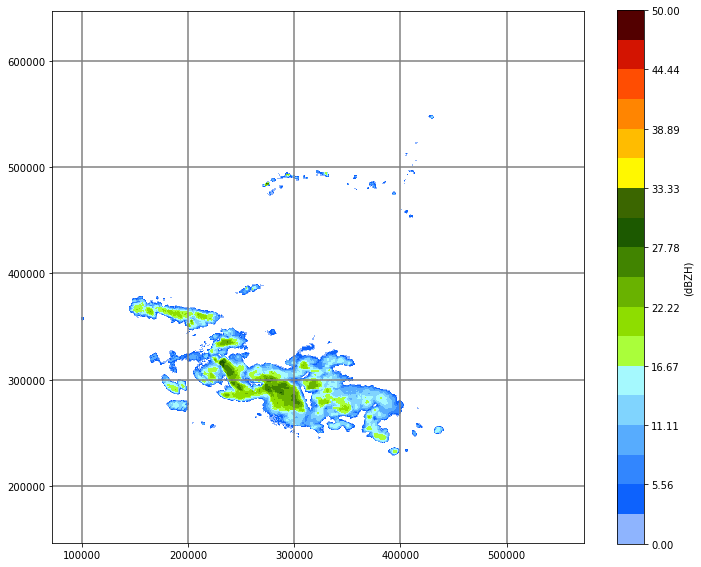

In [19]:
plt.figure(figsize=(10, 8))

# The plot itself
ax = plt.gca()
xy = ax.contourf(trgx,
                  trgy,
                  vol[CAPPI_layer_idx], 
                  unit="dBZH", 
                  levels=np.linspace(0, 50, 19), 
                  cmap=cmap,
                  vmin = 0,
                  vmax = 50, 
                  ticks = np.linspace(0,50,19))
ax.set_aspect('equal', adjustable='box')

plt.grid(color="grey", lw=1.5)

# The colorbar
# ax_cb = plt.axes(( width + height + 0.02, bottom, 0.02, width))
cb = plt.colorbar(xy)
cb.set_label("(%s)" % 'dBZH')

plt.tight_layout()

In [20]:
import os
os.environ["WRADLIB_DATA"] = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/CAPPI analysis/data'


In [21]:

has_data = os.environ.get("WRADLIB_EARTHDATA_USER", False)
has_data

False

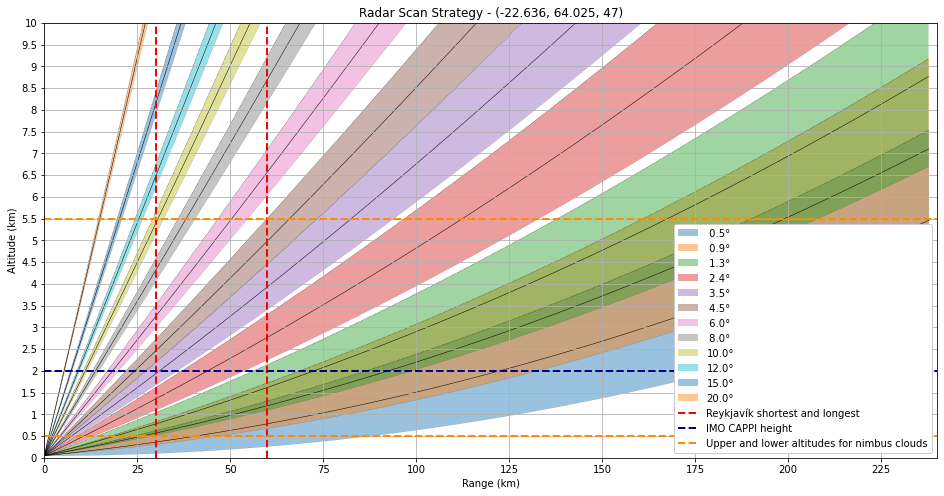

In [111]:
nrays = 420
nbins = 120
range_res = 2000.
ranges = np.arange(nbins) * range_res
elevs = [20, 15, 10, 7, 5, 2.4, 1.3, 0.5]
elevs = [0.5,12.0,15.0,20.0,0.896,1.297,2.396,3.5,4.5,6.0,8.0,10.0,]
elevs = sorted(elevs)
# sitecoords = (7.07, 50.73, 100.0)
sitecoords = (raw["where"]["lon"], raw["where"]["lat"],47)

beamwidth = 1.0

ax = wrl.vis.plot_scan_strategy(ranges = ranges,
                                elevs = elevs,
                                sitecoords = sitecoords,
                                beamwidth = beamwidth,
                                units='km',
                                maxrange = 240_000)




linewidth = 2
ax.vlines([30_000,60_000],0,10_000,color='red',linestyle='--',label='Reykjavík shortest and longest',linewidth = linewidth)
ax.hlines([2_000],0,240_000,color='darkblue',linestyle='--',label='IMO CAPPI height',linewidth = linewidth)
ax.hlines([500,5_500],0,240_000,color='darkorange',linestyle='--',label='Upper and lower altitudes for nimbus clouds',linewidth = linewidth)

ax.artists.pop() # To remove the exta legend outside the plot
plt.legend(framealpha = 1)



In [23]:
sitecoords

(-22.636, 64.025, 47)

## import both raster files and merge them

In [24]:
rasterfile1 = wrl.util.get_wradlib_data_file('IslandsDEMv0_2x2m_zmasl_isn2016_57.tif')
ds = wrl.io.open_raster(rasterfile1)
# ds = wrl.georef.raster.merge_raster_datasets([ds1,ds2])
rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(ds, nodata=-9999.)

## Settings

In [246]:
sitecoords = (raw["where"]["lon"], raw["where"]["lat"],47)
nrays = 420
nbins = 120*10
el = 1.3 # vertical antenna pointing angle (deg)
# el = 0.9 # vertical antenna pointing angle (deg)
bw = 1.0 # beam width (deg)
range_res = 200 #2000.

# Computed
r = np.arange(nbins) * range_res
beamradius = wrl.util.half_power_radius(r, bw)
beamradius_2 = rhalf = (r * np.deg2rad(bw)) / 4.0

In [247]:
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
coords = wrl.georef.spherical_to_proj(coord[..., 0],
                                      coord[..., 1],
                                      coord[..., 2], sitecoords, proj = proj)

lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]

polcoords = coords[..., :2]
print("lon,lat,alt:", coords.shape)

rlimits = (lon.min(), lat.min(), lon.max(), lat.max())
print("Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f" %
      (lat.max(), lon.min(), lon.max(), lat.min()))

lon,lat,alt: (420, 1200, 3)
Radar bounding box:
	436026.81
2282694.87             2761959.30
	-43341.76


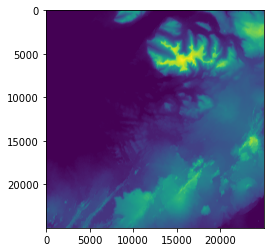

In [248]:
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastervalues_tmp = rastervalues.copy()
rastervalues_tmp[rastervalues_tmp<0] = 0
plt.imshow(rastervalues_tmp)

In [249]:
# Map rastervalues to polar grid points
polarvalues = wrl.ipol.cart_to_irregular_spline(rastercoords, rastervalues,
                                             polcoords, order=3,
                                             prefilter=False)

In [250]:
polarvalues_tmp = wrl.ipol.cart_to_irregular_spline(rastercoords, rastervalues,
                                             polcoords, order=3,
                                             prefilter=False)

In [251]:
PBB = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
PBB = np.ma.masked_invalid(PBB)
print(PBB.shape)
CBB = wrl.qual.cum_beam_block_frac(PBB)
print(CBB.shape)


(420, 1200)
(420, 1200)


C:\Users\sverrirhd\Anaconda3\envs\gis_wradlib_torch\lib\site-packages\wradlib\qual.py:123: RuntimeWarning: divide by zero encountered in true_divide
  ya = y / a
C:\Users\sverrirhd\Anaconda3\envs\gis_wradlib_torch\lib\site-packages\wradlib\qual.py:127: RuntimeWarning: invalid value encountered in sqrt
  numer = (ya * np.sqrt(a ** 2 - y ** 2)) + (a * np.arcsin(ya)) + (np.pi * a / 2.0)
C:\Users\sverrirhd\Anaconda3\envs\gis_wradlib_torch\lib\site-packages\wradlib\qual.py:127: RuntimeWarning: invalid value encountered in arcsin
  numer = (ya * np.sqrt(a ** 2 - y ** 2)) + (a * np.arcsin(ya)) + (np.pi * a / 2.0)


In [252]:
import geopandas as gpd
postnr = gpd.read_file('../Radar data analysis/Radar visualization/Shapefiles/postnr/postnrs.shp')
coords = np.load('../Radar processing/CAPPI_pixel_coords.npy')

transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") # Umbreyta cartesian hnitum aftur í GPS hnit
sitecoords = (-22.636, 64.025, 45.0)
radar_x,radar_y = transformer_gps_isl.transform(sitecoords[1],sitecoords[0])
gauge_x,gauge_y = transformer_gps_isl.transform(64.1275,-21.902)
# x_max,y_max = coords[:,0].max(),coords[:,1].max()
# x_min,y_min = coords[:,0].min(),coords[:,1].min()
radar_width_in_image = (602*240/250+1)
pixel_distance = ((coords[:,:2] - [radar_x,radar_y])**2).sum(axis=1)**0.5
idx_closest_pixel = pixel_distance.argmin()
pixel_distance[idx_closest_pixel],idx_closest_pixel

(141.2839673621651, 180900)

In [253]:
postnr.geometry.translate(radar_x,radar_y)

0      MULTIPOLYGON (((1014214.032 987834.449, 101421...
1      POLYGON ((753893.980 766348.487, 753178.659 76...
2      MULTIPOLYGON (((1006028.637 821158.472, 100613...
3      MULTIPOLYGON (((680093.570 803588.864, 680071....
4      MULTIPOLYGON (((712674.500 978362.956, 712687....
                             ...                        
172    POLYGON ((895425.540 968027.905, 895549.388 96...
173    MULTIPOLYGON (((654516.455 892050.911, 654584....
174    POLYGON ((588746.251 978168.441, 588777.753 97...
175    MULTIPOLYGON (((594153.537 969801.905, 594173....
176    POLYGON ((610437.705 979387.935, 610313.606 97...
Length: 177, dtype: geometry

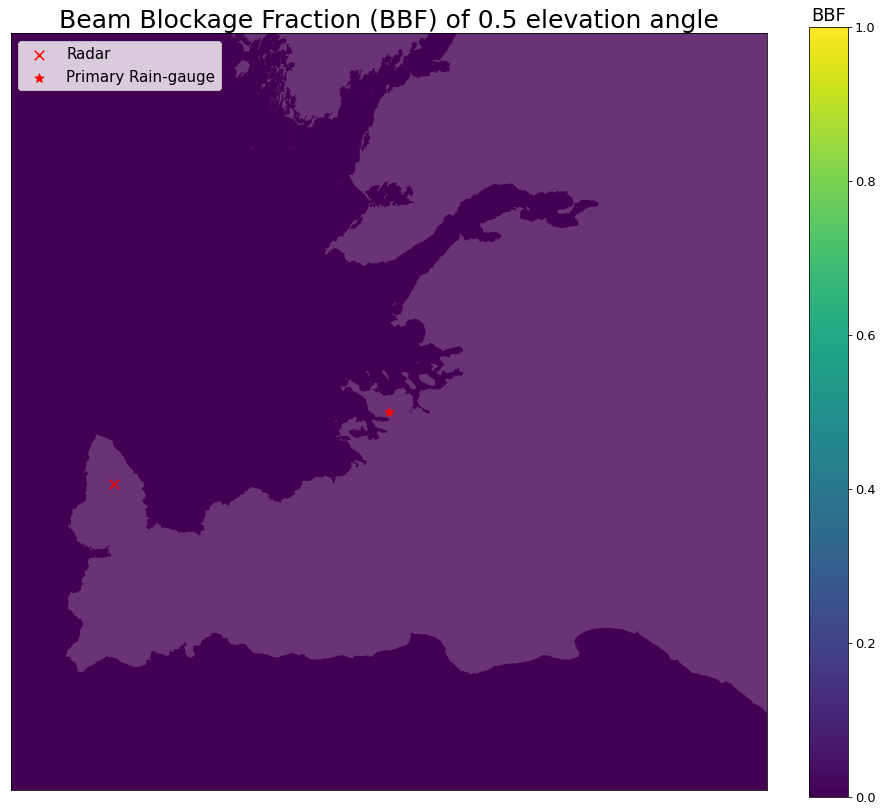

In [254]:
plt.figure(figsize=(15,15))
# postnr.geometry.apply(lambda x : x.boundary).plot(ax = plt.gca())

# plt.scatter(coords[:,0],coords[:,1],c = running_total_image.ravel(),s = 30,marker = 's')
# cbar = plt.colorbar(fraction=0.046)



postnr.geometry.translate(-radar_x,-radar_y).plot(ax = plt.gca(),alpha = 0.2,color='white')

radar_handle = plt.scatter(radar_x-radar_x,radar_y-radar_y,c ='red',marker = 'x',s = 90)
gauge_handle = plt.scatter(gauge_x-radar_x,gauge_y-radar_y,c ='red',marker = '*',s = 90)

plt.ylim(gauge_y - 50_000 - radar_y,gauge_y + 50_000 - radar_y)
plt.xlim(gauge_x - 50_000 - radar_x,gauge_x + 50_000 - radar_x)
plt.xticks([],[])
plt.yticks([],[])
plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
plt.title('Beam Blockage Fraction (BBF) of 0.5 elevation angle',fontsize=25)
plt.legend([radar_handle,gauge_handle],['Radar','Primary Rain-gauge'],loc = 'upper left',fontsize=15)



# proj = osr.SpatialReference()
# proj.ImportFromEPSG(3057)

ax1, dem = wrl.vis.plot_ppi(data = CBB,
                            ax=plt.gca(), 
                            r=r,
                            # site = (radar_x,radar_y,47),
                            az=coord[:,0,1],
                            vmin=0,
                            vmax=1,
                            # proj = None,
                            )
cbar = plt.colorbar(fraction=0.046)
cbar.ax.set_title('BBF',fontsize=18)
cbar.ax.tick_params(labelsize=13)


plt.show()

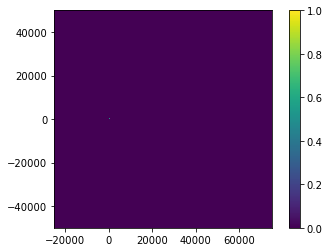

In [255]:
ax1, dem = wrl.vis.plot_ppi(data = CBB,
                            ax=plt.gca(), 
                            r=r,
                            az=coord[:,0,1],
                            vmin=0,
                            vmax=1,
                            )
rad = 50_000
x_shift = 25_000
plt.xlim(-rad+x_shift,rad+x_shift)
plt.ylim(-rad,rad)

img = plt.imshow(np.array([[0,1]]), cmap="viridis")
plt.colorbar(orientation="vertical")
plt.show()

In [256]:
# just a little helper function to style x and y axes of our maps
def annotate_map(ax, cm=None, title=""):
    ticks = (ax.get_xticks()/1000).astype(np.int)
    ax.set_xticklabels(ticks)
    ticks = (ax.get_yticks()/1000).astype(np.int)
    ax.set_yticklabels(ticks)
    ax.set_xlabel("Kilometers")
    ax.set_ylabel("Kilometers")
    if not cm is None:
        plt.colorbar(cm, ax=ax)
    if not title=="":
        ax.set_title(title)
    ax.grid()

In [257]:
polarvalues.max()


901.9117

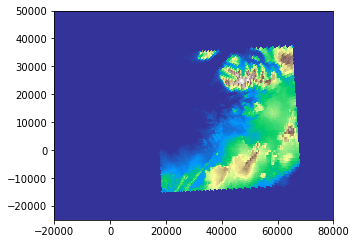

In [258]:
plt.figure(figsize=(5,5))

# Plot terrain (on ax1)
ax1, dem = wrl.vis.plot_ppi(data = polarvalues,
                            ax=plt.gca(), 
                            r=r,
                            az=coord[:,0,1],
                            cmap=mpl.cm.terrain, vmin=0.)
                            
ax1.set_xlim(-20000,80000)
ax1.set_ylim(-25000,50000)
plt.show()



C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_4784/4060411316.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ticks = (ax.get_xticks()/1000).astype(np.int)
C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_4784/4060411316.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)
C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_4784/4060411316.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any

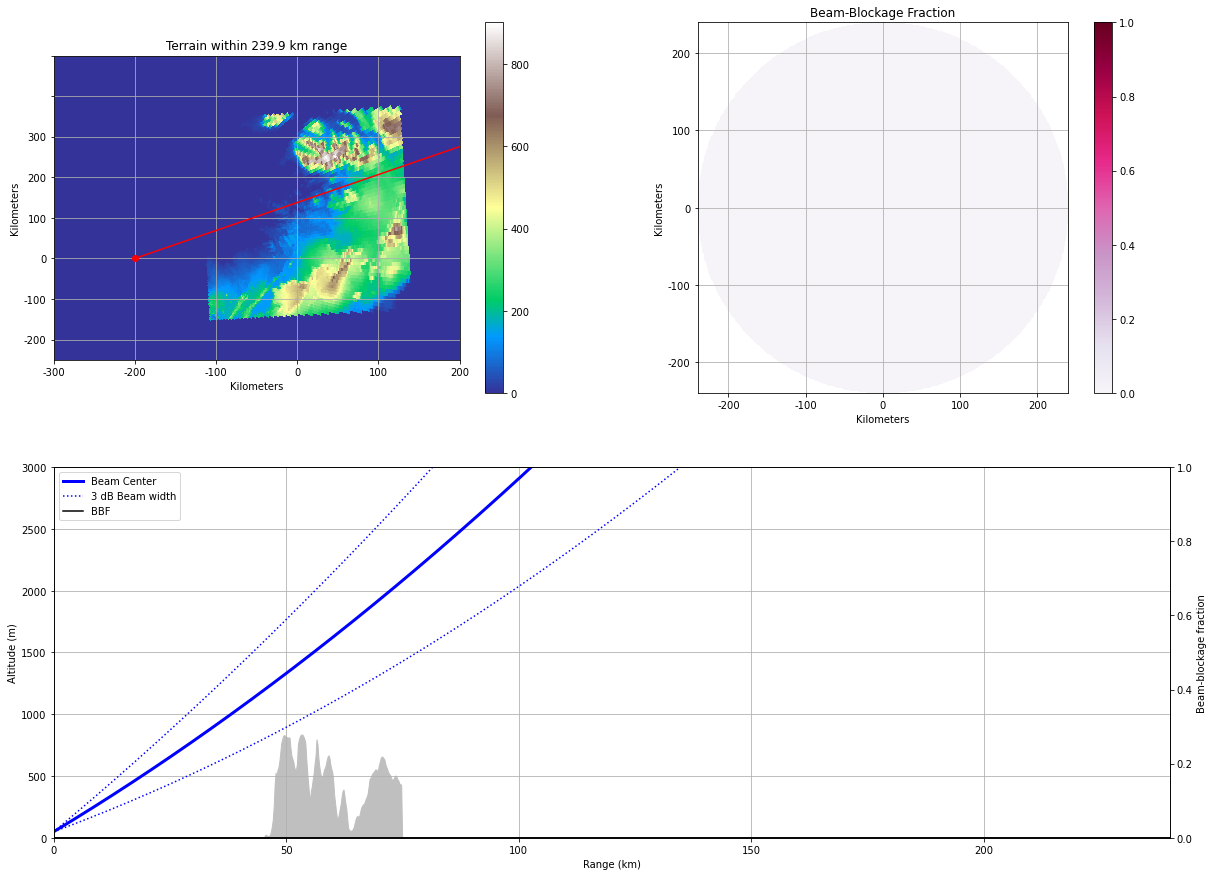

In [259]:
fig = plt.figure(figsize=(20, 15))

# create subplots
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# Max range
max_range = 240_000

# azimuth angle
angle = 71

# Plot terrain (on ax1)
ax1, dem = wrl.vis.plot_ppi(data = polarvalues,
                            ax=ax1, 
                            r=r,
                            az=coord[:,0,1],
                            cmap=mpl.cm.terrain, vmin=0.)
ax1.plot([0,np.sin(np.radians(angle))*max_range],
         [0,np.cos(np.radians(angle))*max_range],"r-")
ax1.plot(sitecoords[0], sitecoords[1], 'ro')
annotate_map(ax1, dem, 'Terrain within {0} km range'.format(np.max(r / 1000.) + 0.1))
ax1.set_xlim(-20000,80000)
ax1.set_ylim(-25000,50000)


# Plot CBB (on ax2)
ax2, cbb = wrl.vis.plot_ppi(CBB, ax=ax2, r=r,
                            az=coord[:,0,1],
                            cmap=mpl.cm.PuRd, vmin=0, vmax=1)
annotate_map(ax2, cbb, 'Beam-Blockage Fraction')

# Plot single ray terrain profile on ax3
bc, = ax3.plot(r / 1000., alt[angle, :], '-b',
               linewidth=3, label='Beam Center')
b3db, = ax3.plot(r / 1000., (alt[angle, :] + beamradius), ':b',
                 linewidth=1.5, label='3 dB Beam width')
ax3.plot(r / 1000., (alt[angle, :] - beamradius), ':b')


ax3.fill_between(r / 1000., 0.,
                 polarvalues[angle, :],
                 color='0.75')
ax3.set_xlim(0., np.max(r / 1000.) + 0.1)
ax3.set_ylim(0., 3000)
ax3.set_xlabel('Range (km)')
ax3.set_ylabel('Altitude (m)')
# ax3.vlines([35440/1000],0,1000)
ax3.grid()

axb = ax3.twinx()
bbf, = axb.plot(r / 1000., CBB[angle, :], '-k',
                label='BBF')
axb.set_ylabel('Beam-blockage fraction')
axb.set_ylim(0., 1.)
axb.set_xlim(0., np.max(r / 1000.) + 0.1)


legend = ax3.legend((bc, b3db, bbf),
                    ('Beam Center', '3 dB Beam width', 'BBF'),
                    loc='upper left', fontsize=10)

In [260]:
sitecoords,sitecoords[0], sitecoords[1]

((-22.636, 64.025, 45.0), -22.636, 64.025)

C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_4784/4060411316.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ticks = (ax.get_xticks()/1000).astype(np.int)
C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_4784/4060411316.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)
C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_4784/4060411316.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any

<Figure size 1440x1080 with 0 Axes>

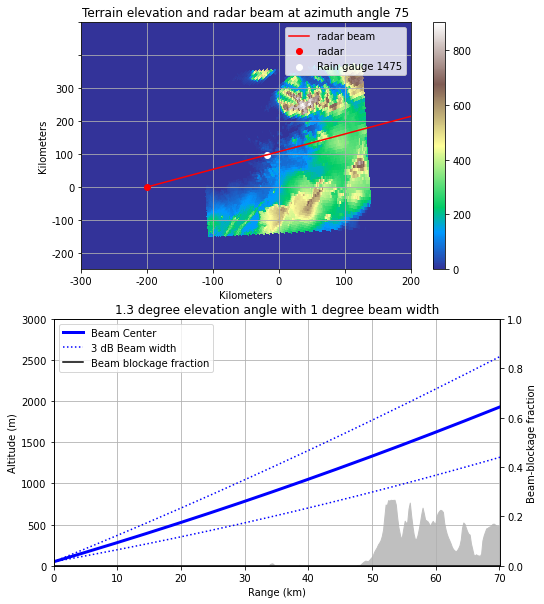

In [261]:
fig = plt.figure(figsize=(20, 15))

# create subplots
f, (ax1,ax3) = plt.subplots(2,1,figsize=(8,10))
# Max range
max_range = 240_000

# azimuth angle
angle = 75

# Plot terrain (on ax1)
ax1, dem = wrl.vis.plot_ppi(data = polarvalues,
                            ax=ax1, 
                            r=r,
                            az=coord[:,0,1],
                            cmap=mpl.cm.terrain, vmin=0.)

ax1.plot([0.,np.sin(np.radians(angle))*max_range],
         [0.,np.cos(np.radians(angle))*max_range],"r-",label='radar beam')
ax1.plot(sitecoords[0], sitecoords[1], 'ro',label = 'radar')
# ax1.plot(gauge_y/1000,gauge_x/1000, 'ro')
# ax1.plot(gauge_x/1000,gauge_y/1000, 'ro')

ax1.scatter(gauge_x-radar_x,gauge_y-radar_y, marker = 'o', color = 'white',label = 'Rain gauge 1475')

# ax1.plot(gauge_y,gauge_x, 'ro')
# ax1.plot(gauge_x,gauge_y, 'ro')

# gauge_x,gauge_y = transformer_gps_isl.transform(64.1275,-21.902)
annotate_map(ax1, dem, 'Terrain elevation and radar beam at azimuth angle 75')
ax1.set_xlim(-20000,80000)
ax1.set_ylim(-25000,50000)
ax1.legend()

# Plot single ray terrain profile on ax3
bc, = ax3.plot(r / 1000., alt[angle, :], '-b',linewidth=3, label='Beam Center')
b3db, = ax3.plot(r / 1000., (alt[angle, :] + beamradius), ':b',linewidth=1.5, label='3 dB Beam width')
ax3.plot(r / 1000., (alt[angle, :] - beamradius), ':b')



# b3db, = ax3.plot(r / 1000., (alt[angle, :] + beamradius_2), ':b',linewidth=1.5, label='3 dB Beam width')
# ax3.plot(r / 1000., (alt[angle, :] - beamradius_2), ':b')


ax3.fill_between(r / 1000., 0.,polarvalues[angle, :],color='0.75')
ax3.set_xlim(0., np.max(r / 1000.) + 0.1)
ax3.set_ylim(0., 3000)
ax3.set_xlabel('Range (km)')
ax3.set_ylabel('Altitude (m)')
ax3.grid()
ax3.set_title(f'{el} degree elevation angle with 1 degree beam width')
dist = ((gauge_x-radar_x)**2 + (gauge_y-radar_y)**2)**0.5
# ax3.vlines([dist/1000],0,1000)

axb = ax3.twinx()
bbf, = axb.plot(r / 1000., CBB[angle, :], '-k',
                label='BBF')
axb.set_ylabel('Beam-blockage fraction')
axb.set_ylim(0., 1.)
# axb.set_xlim(0., np.max(r / 1000.) + 0.1)
axb.set_xlim(0., np.max(70000 / 1000.) + 0.1)


legend = ax3.legend((bc, b3db, bbf),
                    ('Beam Center', '3 dB Beam width', 'Beam blockage fraction'),
                    loc='upper left', fontsize=10)

